In [35]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import xgboost as xgb

In [36]:
from sklearn.metrics import mean_squared_error

In [37]:
df = pd.read_csv('DOM_hourly.csv')
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index, format = '%Y-%m-%d %H:%M:%S')

In [38]:
df.head()

,DOM_MW
Datetime,
2005-12-31 01:00:00,9389.0
2005-12-31 02:00:00,9070.0
2005-12-31 03:00:00,9001.0
2005-12-31 04:00:00,9042.0
2005-12-31 05:00:00,9132.0


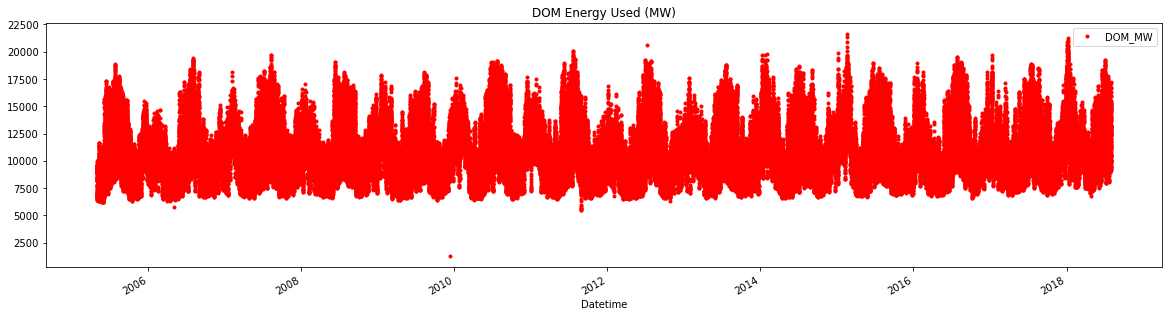

In [39]:
df.plot(style='.', figsize=(20, 5), color='red', title='DOM Energy Used (MW)')
plt.show()

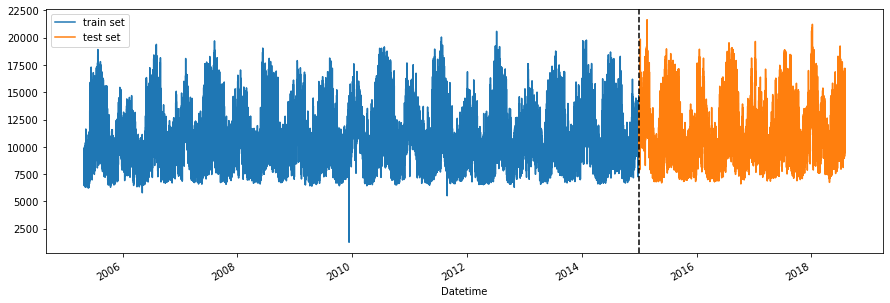

In [40]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']


fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Train Set')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['train set', 'test set'])
plt.show()

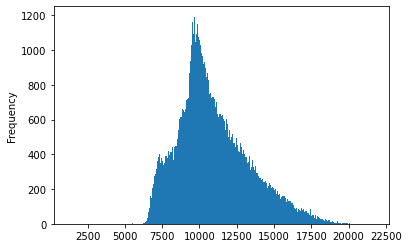

In [42]:
df['DOM_MW'].plot(kind='hist', bins=500)
plt.show()

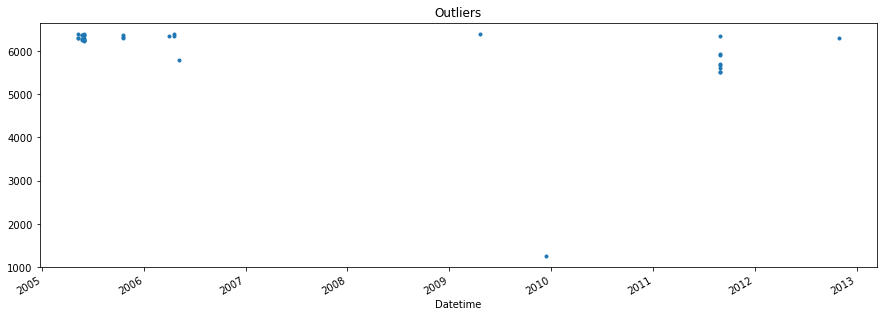

In [60]:
df.query('DOM_MW < 6400')['DOM_MW'].plot(figsize=(15, 5), style='.', title='Outliers')
plt.show()

In [61]:
df = df.query('DOM_MW > 6400').copy()

In [62]:
from sklearn.model_selection import TimeSeriesSplit

In [63]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)

In [64]:
df = df.sort_index()

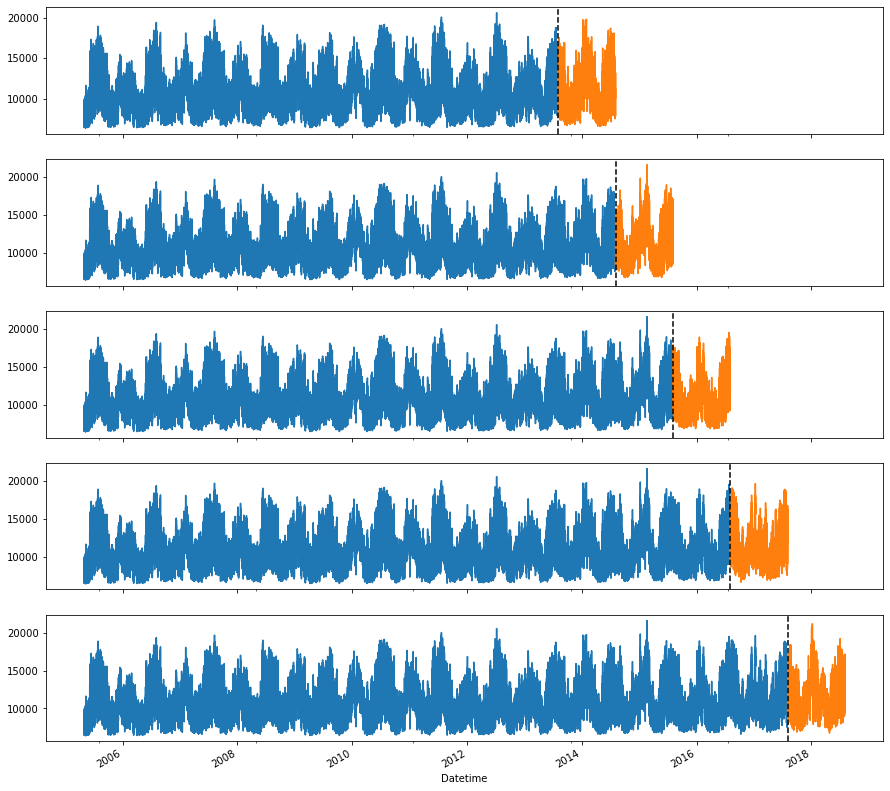

In [66]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0

for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    
    train['DOM_MW'].plot(ax=axs[fold], label='Train Set')
    test['DOM_MW'].plot(ax=axs[fold], label='Test Set')
    axs[fold].axvline(min(test.index), color='black', ls='--')
    fold += 1
plt.show()

In [67]:
def add_feature(df):
    df = df.copy()
    df['Hour'] = df.index.hour
    df['DayofWeek'] = df.index.dayofweek
    df['Quarter'] = df.index.quarter
    df['Month'] = df.index.month
    df['Year'] = df.index.year
    df['DayofYear'] = df.index.dayofyear
    return df

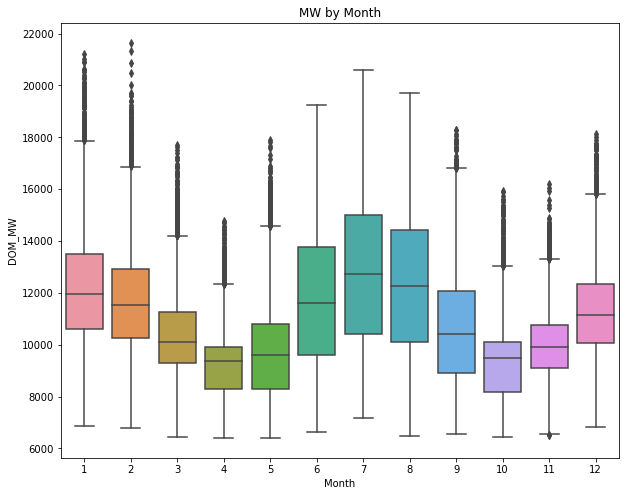

In [68]:
df = add_feature(df)
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='Month', y='DOM_MW')
ax.set_title('MW by Month')
plt.show()

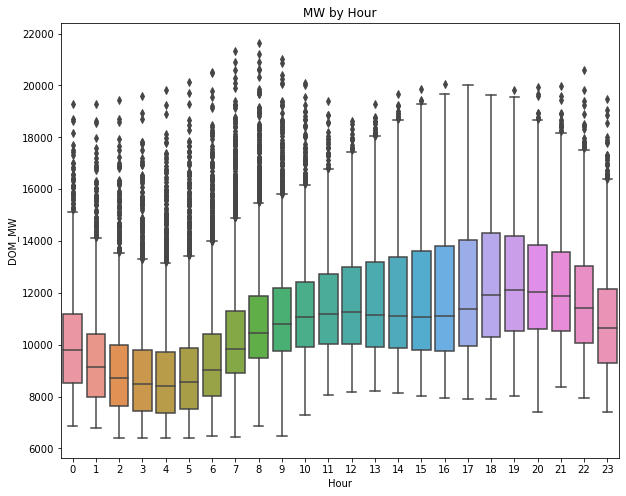

In [69]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='Hour', y='DOM_MW')
ax.set_title('MW by Hour')
plt.show()

In [70]:
predicts = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train = add_feature(train)
    test = add_feature(test)
    
    
    X_train = train.iloc[:, 1:]
    y_train = train['DOM_MW']
    X_test = test.iloc[:, 1:]
    y_test = test['DOM_MW']
    
    reg = xgb.XGBRegressor(n_estimators=500, learning_rate=0.01, booster='gbtree',
                          max_depth=3, base_score=.5, objective='reg:squarederror')
    reg.fit(X_train, y_train, early_stopping_rounds=50,
        eval_set=[(X_train, y_train), (X_test, y_test)], 
        verbose=50)
    y_pred = reg.predict(X_test)
    predicts.append(y_pred)
    scores.append(mean_squared_error(y_test, y_pred))

[0]	validation_0-rmse:10986.33106	validation_1-rmse:11216.69824


C:\Users\FNULNU\.conda\envs\pdata\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[50]	validation_0-rmse:6774.76270	validation_1-rmse:7031.99658
[100]	validation_0-rmse:4288.39062	validation_1-rmse:4571.80566
[150]	validation_0-rmse:2856.20703	validation_1-rmse:3170.95947
[200]	validation_0-rmse:2077.02905	validation_1-rmse:2415.47021
[250]	validation_0-rmse:1669.25757	validation_1-rmse:2042.25964
[300]	validation_0-rmse:1475.79651	validation_1-rmse:1861.73035
[350]	validation_0-rmse:1384.52234	validation_1-rmse:1776.22375
[400]	validation_0-rmse:1336.82947	validation_1-rmse:1736.82996
[450]	validation_0-rmse:1308.65784	validation_1-rmse:1714.84863
[499]	validation_0-rmse:1289.77087	validation_1-rmse:1701.45215
[0]	validation_0-rmse:11011.55762	validation_1-rmse:11458.99414


C:\Users\FNULNU\.conda\envs\pdata\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[50]	validation_0-rmse:6800.00488	validation_1-rmse:7254.08057
[100]	validation_0-rmse:4309.21289	validation_1-rmse:4765.90967
[150]	validation_0-rmse:2875.73999	validation_1-rmse:3334.20312
[200]	validation_0-rmse:2102.12134	validation_1-rmse:2534.62305
[250]	validation_0-rmse:1704.81299	validation_1-rmse:2112.84570
[300]	validation_0-rmse:1515.19360	validation_1-rmse:1888.21423
[350]	validation_0-rmse:1423.62720	validation_1-rmse:1759.59167
[400]	validation_0-rmse:1377.51660	validation_1-rmse:1692.19641
[450]	validation_0-rmse:1349.95837	validation_1-rmse:1651.64172
[499]	validation_0-rmse:1330.21094	validation_1-rmse:1626.41357
[0]	validation_0-rmse:11054.74414	validation_1-rmse:10963.02246


C:\Users\FNULNU\.conda\envs\pdata\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[50]	validation_0-rmse:6830.62549	validation_1-rmse:6725.58350
[100]	validation_0-rmse:4330.87647	validation_1-rmse:4222.32373
[150]	validation_0-rmse:2894.45581	validation_1-rmse:2792.26001
[200]	validation_0-rmse:2119.76318	validation_1-rmse:2025.41248
[250]	validation_0-rmse:1727.67529	validation_1-rmse:1643.95740
[300]	validation_0-rmse:1542.29150	validation_1-rmse:1485.80640
[350]	validation_0-rmse:1453.38745	validation_1-rmse:1451.60632
[400]	validation_0-rmse:1404.50586	validation_1-rmse:1456.15405
[411]	validation_0-rmse:1396.43164	validation_1-rmse:1456.85840
[0]	validation_0-rmse:11046.79297	validation_1-rmse:11271.03125


C:\Users\FNULNU\.conda\envs\pdata\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[50]	validation_0-rmse:6826.51074	validation_1-rmse:7048.61865
[100]	validation_0-rmse:4328.64502	validation_1-rmse:4566.90039
[150]	validation_0-rmse:2892.72461	validation_1-rmse:3150.77319
[200]	validation_0-rmse:2118.83350	validation_1-rmse:2384.97266
[250]	validation_0-rmse:1726.12854	validation_1-rmse:2008.10620
[300]	validation_0-rmse:1540.96814	validation_1-rmse:1823.43762
[350]	validation_0-rmse:1453.09363	validation_1-rmse:1737.30872
[400]	validation_0-rmse:1407.78186	validation_1-rmse:1698.06555
[450]	validation_0-rmse:1381.15015	validation_1-rmse:1683.39258
[499]	validation_0-rmse:1363.67334	validation_1-rmse:1675.26624
[0]	validation_0-rmse:11065.18652	validation_1-rmse:11562.55371


C:\Users\FNULNU\.conda\envs\pdata\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[50]	validation_0-rmse:6838.52686	validation_1-rmse:7356.56348
[100]	validation_0-rmse:4339.08984	validation_1-rmse:4875.07764
[150]	validation_0-rmse:2903.43823	validation_1-rmse:3456.30933
[200]	validation_0-rmse:2132.43115	validation_1-rmse:2673.95288
[250]	validation_0-rmse:1741.74438	validation_1-rmse:2268.88257
[300]	validation_0-rmse:1558.82739	validation_1-rmse:2060.67944
[350]	validation_0-rmse:1472.42602	validation_1-rmse:1955.14429
[400]	validation_0-rmse:1426.80579	validation_1-rmse:1895.42664
[450]	validation_0-rmse:1400.04321	validation_1-rmse:1864.48279
[499]	validation_0-rmse:1382.44653	validation_1-rmse:1847.94849


In [71]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 2772881.4571
Fold scores:[2894939.180323032, 2645223.2085165973, 2102856.166715764, 2806473.495064098, 3414915.23506767]


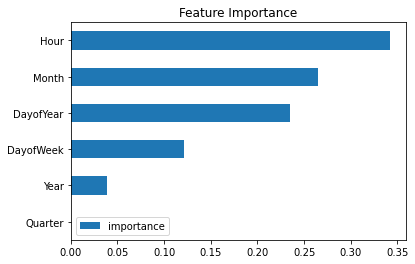

In [72]:
features = pd.DataFrame(data=reg.feature_importances_,
                        columns=['importance'], 
                        index=reg.get_booster().feature_names
                       )
features.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

In [79]:
test['prediction'] = reg.predict(X_test)

In [80]:
temp = df.copy()
temp = temp.merge(test[['prediction']], how='left', left_index=True, right_index=True)

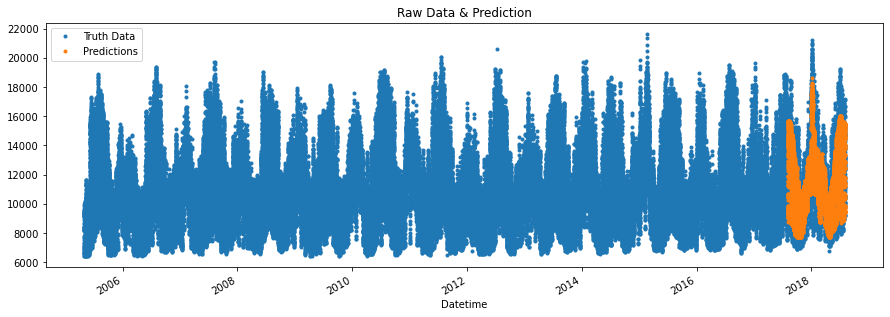

In [81]:
ax = temp[['DOM_MW']].plot(figsize=(15, 5), style='.')
temp['prediction'].plot(ax=ax, style='.')
ax.set_title('Raw Data & Prediction')
ax.legend(['Truth Data', 'Predictions'])
plt.show()

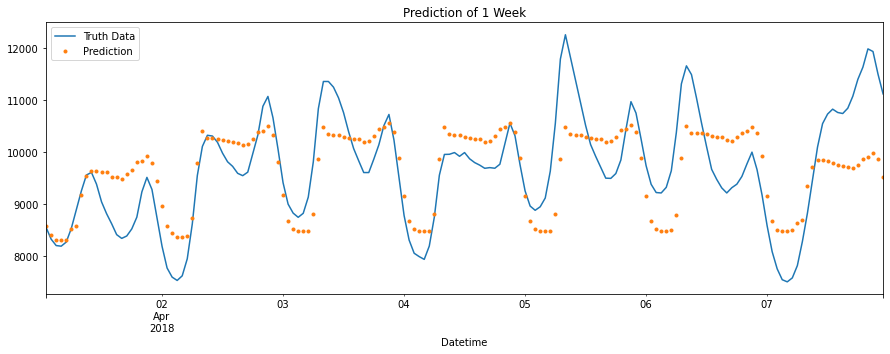

In [84]:
ax = temp.loc[(temp.index > '04-01-2018') & (temp.index < '04-08-2018')]['DOM_MW'].plot(figsize=(15, 5), 
                                                                                        title='Prediction of 1 Week')
temp.loc[(temp.index > '04-01-2018') & (temp.index < '04-08-2018')]['prediction'].plot(style='.')
ax.legend(['Truth Data', 'Prediction'])
plt.show()

In [86]:
score = np.sqrt(mean_squared_error(test['DOM_MW'], test['prediction']))
score

1202.086510123042

In [87]:
test['error'] = np.abs(test['DOM_MW'] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=True).head()

date
2018-08-03     33.070312
2017-09-14    176.700399
2017-10-14    206.101603
2017-11-02    225.407043
2018-07-12    237.678345
Name: error, dtype: float64

In [88]:
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head()

date
2017-12-28    3619.020304
2017-10-09    2516.669067
2018-01-14    2389.661947
2017-10-10    2375.492330
2017-12-13    2332.364665
Name: error, dtype: float64

In [73]:
#retrain on all data to predict the future
df = add_feature(df)
X = df.iloc[:, 1:]
y = df.iloc[:, 0]
reg = xgb.XGBRegressor(n_estimators=500, learning_rate=0.01)
reg.fit(X, y, early_stopping_rounds=50,
        eval_set=[(X, y)], 
        verbose=50)

[0]	validation_0-rmse:11102.66211


C:\Users\FNULNU\.conda\envs\pdata\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[50]	validation_0-rmse:6815.18652
[100]	validation_0-rmse:4267.16260
[150]	validation_0-rmse:2794.98853
[200]	validation_0-rmse:1991.92725
[250]	validation_0-rmse:1584.75415
[300]	validation_0-rmse:1389.05627
[350]	validation_0-rmse:1288.84143
[400]	validation_0-rmse:1232.37439
[450]	validation_0-rmse:1202.90308
[499]	validation_0-rmse:1180.27295


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=500, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [74]:
df.index.max()

Timestamp('2018-08-03 00:00:00')

In [75]:
future = pd.date_range('2018-08-03', '2019-08-03', freq='1h')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])
df_and_future = add_feature(df_and_future)

In [76]:
future_features = df_and_future.query('isFuture').copy()
future_features

,DOM_MW,Hour,DayofWeek,Quarter,Month,Year,DayofYear,isFuture
2018-08-03 00:00:00,NaN,0,4,3,8,2018,215,True
2018-08-03 01:00:00,NaN,1,4,3,8,2018,215,True
2018-08-03 02:00:00,NaN,2,4,3,8,2018,215,True
2018-08-03 03:00:00,NaN,3,4,3,8,2018,215,True
2018-08-03 04:00:00,NaN,4,4,3,8,2018,215,True
...,...,...,...,...,...,...,...,...
2019-08-02 20:00:00,NaN,20,4,3,8,2019,214,True
2019-08-02 21:00:00,NaN,21,4,3,8,2019,214,True
2019-08-02 22:00:00,NaN,22,4,3,8,2019,214,True
2019-08-02 23:00:00,NaN,23,4,3,8,2019,214,True


In [77]:
future_features['prediction'] = reg.predict(future_features[['Hour', 'DayofWeek', 'Quarter', 'Month', 'Year', 'DayofYear']])

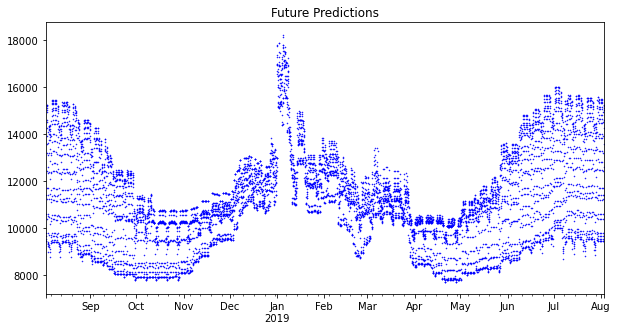

In [78]:
future_features['prediction'].plot(figsize=(10, 5), color='blue', 
                             ms=1, lw=1, title='Future Predictions', style='.')
plt.show()

In [ ]:
# reg.save_model('model.json')

In [ ]:
# reg_new = xgb.XGBRegressor()
# reg_new = load_model('model.json')